<a href="https://colab.research.google.com/github/bmijangos/ProyectoIntegrador/blob/main/Avance2_Equipo21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Tecnológico de Monterrey**

# **Proyecto Integrador**
## Avance 2
## Análisis exploratorio de datos
###Dra. Grettel Barceló Alonso
###EQUIPO 21
###Bernardo Mijango Flores - A01793654
###Dalia Isabel López Tapia - A01245026
###David Valles Canedo - A01191310
12 de mayo de 2024

### Importaciones, Dependencias y Pasos Iniciales

In [ ]:
# conectamos al drive de google para la lectura de los archivos csv
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns   # para un mejor despliegue de los gráficos
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


In [ ]:
# Lectura de los archivos csv
file_path = '/content/drive/MyDrive/DataSetProyecto/GrupalTodo.csv'

label = ["IdCliente","FechaAltaCliente","CodigoGrupo","EdadCliente","Genero","EstadoCivil","Escolaridad","CapacidadPago","Localidad","CodigoSucursal","CodigoASesor","NumeroCredito","CicloCliente","FechaDesembolso","FechaVencimiento","FechaCancelacion","Plazo","PeriodoPago","EstatusCredito","MontoCredito","CuotaNumero","CuotaFechaVencimiento","CuotaFechaCancelacion","MontoCuota","MontoCapital","SaldoCapital","EstatusCuota","DiasAtraso"]

# Obtenemos el dataframe
pagos_df = pd.read_csv(file_path, names=label)

pagos_df.shape

(4254537, 28)

In [ ]:
# Agregamos los datos del segundo archivo de castigos
file_path = '/content/drive/MyDrive/DataSetProyecto/GrupalTodoCastigos.csv'

castigos_df = pd.read_csv(file_path)

castigos_df.shape

(127677, 28)

In [ ]:
# unimos los dos dataframes en uno solo
grupal_df = pd.concat([pagos_df, castigos_df], axis=0)

In [ ]:
grupal_df.shape

(4382214, 28)

In [ ]:
grupal_df.isnull().sum()

IdCliente                   0
FechaAltaCliente            0
CodigoGrupo                 0
EdadCliente                 0
Genero                      0
EstadoCivil                 0
Escolaridad              1243
CapacidadPago               0
Localidad                   0
CodigoSucursal              0
CodigoASesor                0
NumeroCredito               0
CicloCliente                0
FechaDesembolso             0
FechaVencimiento            0
FechaCancelacion            0
Plazo                       0
PeriodoPago                 0
EstatusCredito              0
MontoCredito                0
CuotaNumero                 0
CuotaFechaVencimiento       0
CuotaFechaCancelacion     128
MontoCuota                  0
MontoCapital                0
SaldoCapital                0
EstatusCuota                0
DiasAtraso                128
dtype: int64

In [ ]:
# eliminamos los valores nulos
gpdf = grupal_df.dropna()

In [ ]:
print(gpdf.Genero.describe())
print(gpdf.Escolaridad.describe())
print(gpdf.PeriodoPago.describe())
print(gpdf.EstatusCredito.describe())

count     4380844
unique          2
top             F
freq      4378507
Name: Genero, dtype: object
count     4380844
unique         14
top            1A
freq      1302653
Name: Escolaridad, dtype: object
count          4380844
unique               3
top       CATORCENA(S)
freq           3816897
Name: PeriodoPago, dtype: object
count     4380844
unique          2
top           CAN
freq      4253254
Name: EstatusCredito, dtype: object


In [ ]:
# se eliminar los registros de clientes con mas de 80 años

gpdf.drop( gpdf[gpdf['EdadCliente'] > 80].index, axis=0, inplace=True)

<ipython-input-11-a779e5281e75>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gpdf.drop( gpdf[gpdf['EdadCliente'] > 80].index, axis=0, inplace=True)


### Avance 2

In [ ]:
# Seleccion de caracteristicas
features = ['EdadCliente', 'Genero', 'CicloCliente','Plazo', 'MontoCredito', 'MontoCapital', 'SaldoCapital', 'MontoCuota','DiasAtraso','EstadoCivil','EstatusCredito', 'Escolaridad']


In [ ]:
newgpdf = gpdf[features]
newgpdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4334903 entries, 13 to 127676
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   EdadCliente     int64  
 1   Genero          object 
 2   CicloCliente    int64  
 3   Plazo           int64  
 4   MontoCredito    float64
 5   MontoCapital    float64
 6   SaldoCapital    float64
 7   MontoCuota      float64
 8   DiasAtraso      float64
 9   EstadoCivil     int64  
 10  EstatusCredito  object 
 11  Escolaridad     object 
dtypes: float64(5), int64(4), object(3)
memory usage: 429.9+ MB


In [ ]:
 num_variables = ['EdadCliente', 'MontoCredito', 'Plazo', 'MontoCuota', 'MontoCapital', 'SaldoCapital', 'DiasAtraso']
 cat_variables = ['Genero', 'EstatusCredito', 'Escolaridad']

In [ ]:
# solo variables numerica
x_num = newgpdf[num_variables]

#### Preprocesamiento y creacion de pipeline

In [ ]:
# fase de Escalamiento y normalizacion
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])


In [ ]:
# fase de Codificacion de categorias
cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

In [ ]:
# pipeline con metodos de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_variables),
        ('cat', cat_pipeline, cat_variables)
    ])

#### Correlación

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = x_num.corr()

# visualizar la matriz de correlación
print("Matriz de correlación en var numericas:")
print(correlation_matrix)

# características más correlacionadas con umbral del .5
threshold = 0.5
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

print("\nCaracterísticas correlacionadas:")
print(highly_correlated_features)

Matriz de correlación en var numericas:
              EdadCliente  MontoCredito     Plazo  MontoCuota  MontoCapital  \
EdadCliente      1.000000      0.076541  0.131713    0.041916      0.041870   
MontoCredito     0.076541      1.000000  0.210279    0.955643      0.930933   
Plazo            0.131713      0.210279  1.000000   -0.000233     -0.030958   
MontoCuota       0.041916      0.955643 -0.000233    1.000000      0.985013   
MontoCapital     0.041870      0.930933 -0.030958    0.985013      1.000000   
SaldoCapital    -0.013478      0.067307 -0.029394    0.076448      0.090903   
DiasAtraso      -0.011307     -0.021255 -0.037901   -0.013932     -0.008767   

              SaldoCapital  DiasAtraso  
EdadCliente      -0.013478   -0.011307  
MontoCredito      0.067307   -0.021255  
Plazo            -0.029394   -0.037901  
MontoCuota        0.076448   -0.013932  
MontoCapital      0.090903   -0.008767  
SaldoCapital      1.000000    0.378782  
DiasAtraso        0.378782    1.000000  

#### Umbral de Varianza

In [ ]:

# Aplicar umbral de varianza con threshold de .1
threshold = 0.1
selector = VarianceThreshold(threshold=threshold)
X_selected = selector.fit_transform(x_num)

# Obtener los nombres de las características seleccionadas
selected_features = x_num.columns[selector.get_support()]

# Mostrar las características seleccionadas
print("Características seleccionadas con varianza superior al umbral:")
print(selected_features)

Características seleccionadas con varianza superior al umbral:
Index(['EdadCliente', 'MontoCredito', 'Plazo', 'MontoCuota', 'MontoCapital',
       'SaldoCapital', 'DiasAtraso'],
      dtype='object')


#### PCA

In [ ]:
pca_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=2))
])


In [ ]:
principal_components = pca_pipeline.fit_transform(newgpdf)

In [ ]:
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [ ]:
# Exploración de la varianza
print("Varianza explicada por cada componente principal:")
print(pca_pipeline.named_steps['pca'].explained_variance_ratio_)



Varianza explicada por cada componente principal:
[0.37219044 0.17848539]


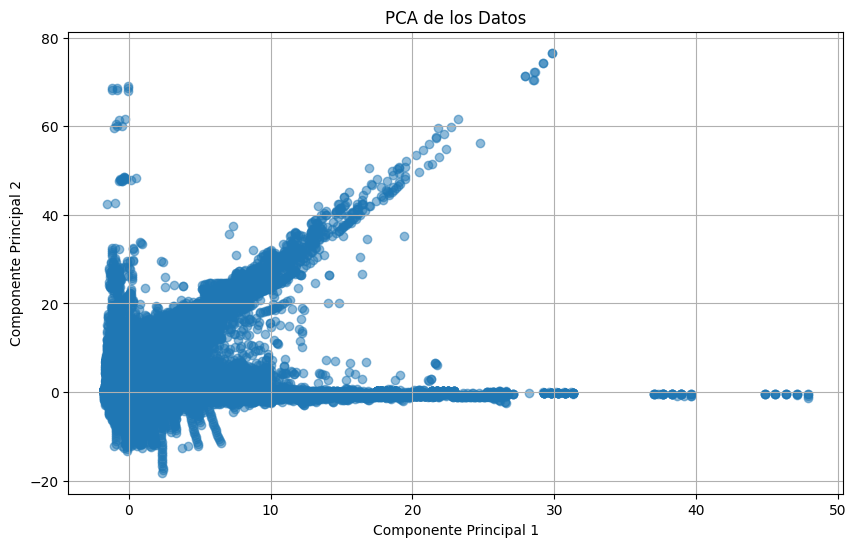

In [ ]:
# plot
plt.figure(figsize=(10, 6))
plt.scatter(principal_df['PC1'], principal_df['PC2'], alpha=0.5)
plt.title('PCA de los Datos')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

#### Generacion de nuevas caracteristicas con LLama3

La idea detras de generar conversaciones y acciones, es poder entrenar el modelo llama3 con un fine tune especifico a nuestras situacciones y acciones. Los datos se generan sintenticamente por un modelo LLM y los resultados son evaluados por expertos en el area.

In [ ]:
!pip install transformers

In [ ]:
!pip install accelerate

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
import transformers
import torch

model_id = "meta-llama/Meta-Llama-3-8B"

text_generator = transformers.pipeline(
    "text-generation", model=model_id, model_kwargs={"torch_dtype": torch.bfloat16}, device_map="auto"
)
template = "context: genera json con las posibles acciones:cobrar pago, resolver dudas, reportar pago. \nconversacion: {conversation}\n Accion: {action}\n"

generated_data = text_generator(template, max_length=50, do_sample=True, temperature=0.7, top_k=50)

# Print the generated data
print(generated_data[0]['generated_text'])

ImportError: Using `low_cpu_mem_usage=True` or a `device_map` requires Accelerate: `pip install accelerate`